<a href="https://colab.research.google.com/github/joaquinhojman/ArbolesDeDecision/blob/main/XGBoost_with_RandomSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve


from sklearn.model_selection import train_test_split

In [2]:
url_train = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_train.csv'
url_test = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test.csv'

data_train = pd.read_csv(url_train) #se usa para entrenar el modelo
data_test = pd.read_csv(url_test) #se usa para predecir

In [3]:
#Separo el data frame de train en uno para entrenar y uno para probar.
model_train, model_test = train_test_split(data_train, test_size=.2, random_state=1999)


In [4]:
# Supongo que el DataFrame con el que trabajo se llama 'data_train'
# 'x' son los datos (todas las columnas menos el target), 'y' es el target
x, y = data_train.iloc[:, :-1], data_train.iloc[:, -1]

# 'x' son los datos --> x_train son los datos con los que entrenar
#                   --> x_test son los datos con los que probar
# 'y' es el target  --> y_train son las soluciones con las que comparar lo entrenado con x_train
#                   --> y_test son las soluciones con las que comparar lo probado con x_test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1999)

#Esto lo hizo chechu y esta bien, no cambiar.

In [5]:
 xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5 , 
                           alpha = 10, n_estimators = 30, eta=0.2,nthread=2,objective='binary:logistic',
                           booster='gbtree',max_features=12,error='log_loss')
 xg_reg.fit(x_train, y_train)
 preds = xg_reg.predict(x_test)


In [6]:
error = log_loss(y_test, preds)
error

0.2942856429622519

In [7]:
preds_train = xg_reg.predict(x_train)
error_train = log_loss(y_train, preds_train)
error_train

0.27881332698502215

#K-fold cross validation

In [8]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

In [9]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

In [10]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.476951,0.000229,0.477541,0.000279
1,0.458026,0.002110,0.459368,0.002134
2,0.443375,0.000571,0.445309,0.000690
3,0.428358,0.001690,0.430640,0.001294
4,0.415144,0.001540,0.418113,0.001513


In [11]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.286547
Name: test-rmse-mean, dtype: float64


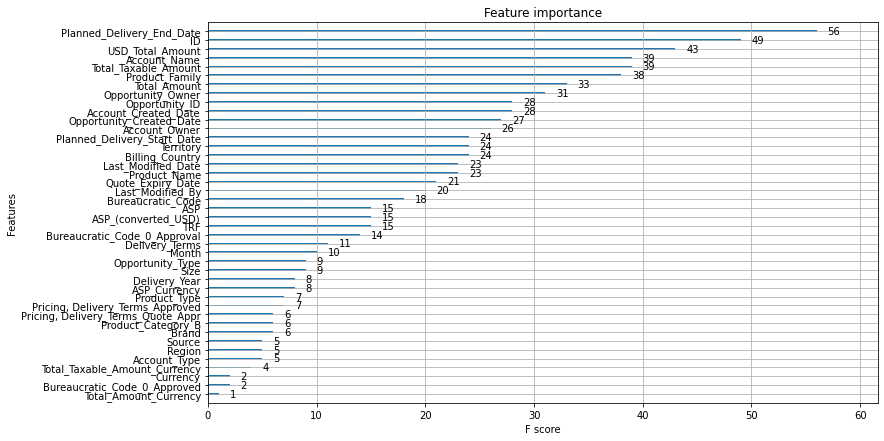

In [12]:
## Importancia de los features (cuantas veces aparecen en los árboles)
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

TUNEANDO HIPERPARAMETROS

In [ ]:
from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
    'classifier__learning_rate': np.array([0.1,0.01,0.001]),
    'classifier__n_estimators': np.array([100,200,300,400]),
    'classifier__subsample': np.array([0.7,0.8,0.9]),
    'classifier__max_depth': np.array([10,11,12,13,14,15,16,17]),
    'classifier__lambda': np.array([1]),
    'classifier__gamma': np.array([0]),
    'penalty' : ['l1', 'l2'], 'C':np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]),
    'class_weight':np.array([{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]),
     'solver':   ['liblinear', 'saga']                    
    #'classifier__colsample_bytree': np.arange(0,1.1,.2)
}

grid = GridSearchCV(estimator=xg_reg, param_grid=gbm_param_grid, n_jobs= -1,
                         scoring='f1_weighted', verbose=10)

grid_result = grid.fit(x_train, y_train)



Fitting 5 folds for each of 36864 candidates, totalling 184320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.2s


ValueError: ignored

In [ ]:
predsGS = xg_reg.predict(x_test)
error = log_loss(y_test,predsGS)
error

0.2958549508785783

In [13]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [14]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = preds

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [15]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.3145570567777804

In [ ]:
preds_testRSDT = xg_reg.predict(data_test)
preds_testRSDT

array([0.05613064, 0.9440591 , 0.9055025 , ..., 0.12035374, 0.1019301 ,
       0.07812417], dtype=float32)

In [ ]:
# Sacamos el preds_test_agrupado_por_opp
url_test = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test.csv'
data_test = pd.read_csv(url_test) #se usa para predecir

preds_testRSDT = xg_reg.predict(data_test)

oportunidades_testGV = data_test['Opportunity_ID'].to_frame()

oportunidades_testGV['Target'] = preds_testRSDT

preds_test_agrupado_por_oppGV = oportunidades_testGV.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_agrupado_por_oppGV = preds_test_agrupado_por_oppGV.reset_index()

preds_test_agrupado_por_oppGV

,Opportunity_ID,Target
0,10689,0.635891
1,10690,0.586675
2,10691,0.213188
3,10692,0.419037
4,10693,0.919348
...,...,...
1562,12364,0.848123
1563,12365,0.303578
1564,12366,0.288932
1565,12367,0.130610


In [ ]:
from google.colab import files

preds_test_agrupado_por_oppGV.to_csv('preds_testxgb.csv', index=False, header=True)
files.download('preds_testxgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>